# Evaluating Geneformer PBMC cell embeddings

This code imports necessary libraries, filters out certain types of warnings, and imports modules and custom logging objects for use in subsequent operations, related to evaluating the Geneformer model.

In [1]:
import pandas as pd

import Geneformer
import torch

import os
import logging
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from sc_foundation_evals import geneformer_forward as gf
from sc_foundation_evals import data, cell_embeddings, model_output
from sc_foundation_evals.helpers.custom_logging import log
log.setLevel(logging.INFO)

/hpc/compgen/users/nlandzaat/Software/anaconda3/envs/project_env_test/lib/python3.9/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/hpc/compgen/users/nlandzaat/Software/anaconda3/envs/project_env_test/lib/python3.9/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using

#### Setting up variables

In the following code snippets, paths and parameters are set up for running a preprocessing pipeline using the Geneformer framework on the 68K PBMC single-cell RNA sequencing data stored in the AnnData object (adata_GF). It specifies paths for input data, the pre-trained Geneformer model, and output directories. Additionally, it defines parameters such as the column names for gene names, batch information, labels, and raw counts within the AnnData object. Note that the batch column is set to 'cell_names' because the dataset consists of only one batch, which only includes cells of the same type.

In [2]:
# path for saving results
file_path_out_GF = "/home/cog/nlandzaat/rep_learning_sc_foundation/analysis/nlandzaat/4. output/GFoutput"

# path to pre-trained Geneformer:
GF_dir = "/home/cog/nlandzaat/rep_learning_sc_foundation/Geneformer"
dict_dir = os.path.join(GF_dir, "geneformer")

# if possible, use multithreading specify num_workers, -1 means use all available
num_workers = -1

In [3]:
# specify the path to AnnData object
in_dataset_path = "/home/cog/nlandzaat/rep_learning_sc_foundation/raw/PBMC/adata_GF.h5ad"
# dataset_name is inferred from in_dataset_path
dataset_name = os.path.basename(in_dataset_path).split(".")[0]
# specify the path for the output of the pre-processing
preprocessed_path = f"/home/cog/nlandzaat/rep_learning_sc_foundation/analysis/nlandzaat/{dataset_name}/"
# create the preprocessed path if it does not exist
os.makedirs(preprocessed_path, exist_ok=True)


# in which column in adata.obs are gene names stored? if they are in index, the index will be copied to a column with this name
gene_col = "gene_symbols" 
# batch column found in adata.obs
batch_col = "cell_names"
# where are labels stored in adata.obs? 
label_col = "cell_names" 
# where the raw counts are stored?
layer_key = "counts" 

### Loading model and data

The provided code initializes a Geneformer model instance, loads the pretrained model and vocabulary, and prepares input data for subsequent processing and analysis. The input data object is created using the InputData class from the data module. This object represents the input dataset (AnnData object of the 68k PBMC data set) that will be processed using Geneformer.

In [6]:
# create Geneformer instance
geneform = gf.Geneformer_instance(save_dir = file_path_out_GF, 
                                  saved_model_path = GF_dir,
                                  explicit_save_dir = True,
                                  num_workers = num_workers)

INFO     | 2024-04-02 12:41:47 | Using device cuda


In [7]:
# load pretrained model
geneform.load_pretrained_model()

INFO     | 2024-04-02 12:42:22 | Model successfully loaded from /home/cog/nlandzaat/rep_learning_sc_foundation/Geneformer


In [8]:
# load vocabulary
geneform.load_vocab(dict_dir)

In [9]:
# create input data object
input_data = data.InputData(adata_dataset_path = in_dataset_path)

INFO     | 2024-04-02 12:42:22 | Loading data from /home/cog/nlandzaat/rep_learning_sc_foundation/raw/PBMC/adata_GF.h5ad


The input data is preprocessed ensuring that it is formatted correctly and ready for input into the Geneformer model. Preprocessing matches the gene names to the vocabulary and filters cells and genes. A new AnnData object is created and saved to the preprocessed_path to a .loom file. 

In [10]:
# preprocess data
input_data.preprocess_data(gene_col = gene_col,
                           model_type = "geneformer",
                           save_ext = "loom",
                           gene_name_id_dict = geneform.gene_name_id,
                           preprocessed_path = preprocessed_path)

WARNING  | 2024-04-02 12:43:31 | Gene names not found in var columns. Using index instead.
INFO     | 2024-04-02 12:45:40 | Matched 99.69% genes (13946/13990) genes in vocabulary of size 40248.


Tokenization breaks the input down into smaller units, making the data more suitable for processing by Geneformer. The tokenized data is saved to the preprocessed_path.

In [11]:
# tokenize data
geneform.tokenize_data(adata_path = os.path.join(preprocessed_path, 
                                                 f"{dataset_name}.loom"),
                       dataset_path = preprocessed_path,
                       cell_type_col = label_col)

Tokenizing /home/cog/nlandzaat/rep_learning_sc_foundation/analysis/nlandzaat/adata_GF/adata_GF.loom
/home/cog/nlandzaat/rep_learning_sc_foundation/analysis/nlandzaat/adata_GF/adata_GF.loom has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


Map (num_proc=4):   0%|          | 0/68579 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/68579 [00:00<?, ? examples/s]

### Evaluating embeddings

A forward pass on the model is conducted to extract embeddings. The extraction process employs a batch size of 24, determining the number of samples processed simultaneously during each iteration. The embeddings are extracted from the second-to-last layer, following the guidelines outlined in the Geneformer codebase. Utilizing the 'layer' argument, layers can be referenced based on Python conventions, where 0 represents the embedding layer, 1 denotes the first layer, 2 signifies the second layer, and so forth, with -1 indicating the last layer.

Then, we initialize an evaluation object to assess gene expression predictions using the extracted embeddings. The evaluation includes predictions for a specified number of cells (in this case, 500), and rankings are saved as part of the evaluation process.

In [12]:
# extract embeddings
geneform.extract_embeddings(data = input_data,
                            batch_size = 24, # batch_size depends on available GPU memory; should be a multiple of 8
                            layer = -2)

Geneformer (extracting embeddings):   0%|          | 0/2858 [00:00<?, ?it/s]

In [13]:
# save embeddings to a DataFrame
GF_embeddings_df = pd.DataFrame(geneform.cell_embeddings)

# save the DataFrame with embeddings to a CSV file
GF_embedding_file_path = "/home/cog/nlandzaat/rep_learning_sc_foundation/analysis/nlandzaat/4. output/GF_embeddings_PBMC.csv"
GF_embeddings_df.to_csv(GF_embedding_file_path, index=False)

In [14]:
eval_pred = model_output.GeneExprPredEval(geneform, 
                                          output_dir = file_path_out_GF)

In [15]:
eval_pred.evaluate(n_cells = 500,
                   save_rankings = True)

,correlation,mean_correlation
count,500.000000,500.000000
mean,0.938659,0.774740
std,0.032562,0.072639
min,0.826249,0.390798
25%,0.917588,0.756990
50%,0.940345,0.790701
75%,0.958814,0.820844
max,1.000000,0.890719


## Evaluate cell embeddings

This code initializes an evaluation object for cell embeddings using the Geneformer model. Then, it proceeds to visualize the embeddings in a UMAP, using a subset of 1000 cells to speed up the process.

In [16]:
# create cell embedding evaluation object
eval_ce = cell_embeddings.CellEmbeddingsEval(geneform,
                                             data = input_data,
                                             output_dir = file_path_out_GF,
                                             label_key = label_col,
                                             batch_key = batch_col)

WARNING  | 2024-04-02 12:59:07 | adata_ has 68579 cells. Taking a subset of 1000 cells.


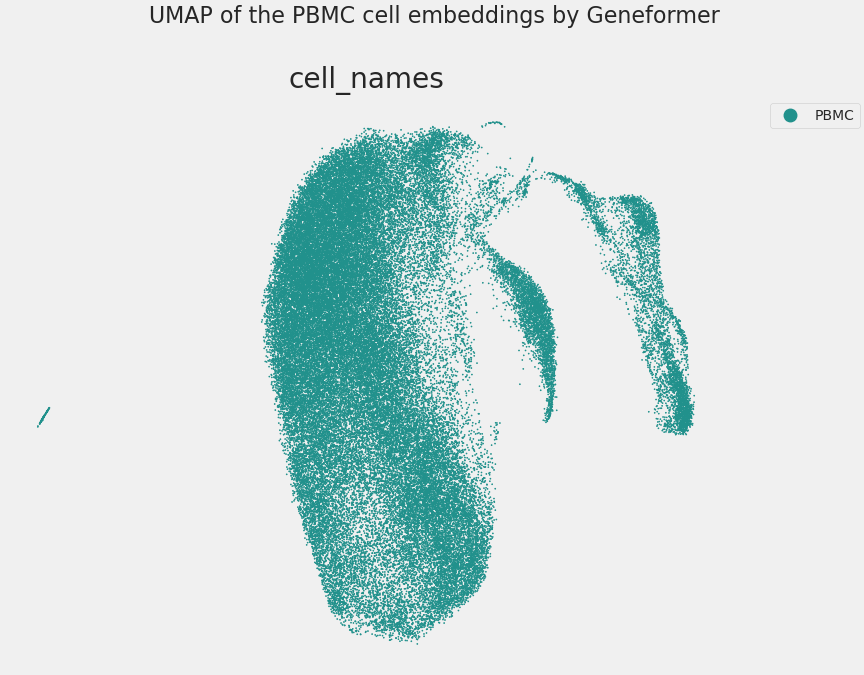

In [17]:
# visualize embeddings
eval_ce.visualize(n_cells = 1000, embedding_key = "geneformer", plot_title = "UMAP of the PBMC cell embeddings by Geneformer")